# ECE 57000 Assignment 3 Exercise

Your Name: Cole Richardson

Prepare the pacakge we will use.

In [29]:
import time
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

## Exercise 0: Train your model on GPU (0 points)

Some tasks in this assignment can take a long time if you run it on the CPU. For example, based on our solution of Exercise 3 Task 4 (Transfer Learning: finetuning of a pretrained model (resnet18)), it will take roughly 2 hours to train the model end-to-end (complete model and not only the last fc layer) for 1 epoch on CPU. Hence, we highly recommend you try to train your model on GPU.

To do so, first you need to enable GPU on Colab (this will restart the runtime). Click `Runtime`-> `Change runtime type` and select the `Hardware accelerator` there.  You can then run the following code to see if the GPU is correctly initialized and available.

**Note**: If you would like to avoid GPU overages on Colab, we would suggest writing and debugging your code before switching on the GPU runtime. Otherwise, the time you spent debugging code will likely count against your GPU usage. Once you have the code running, you can switch on the GPU runtime and train the model much faster.

In [30]:
print(f'Can I can use CUDA now? -- {torch.cuda.is_available()}')
print(f'Can I use Metal Performance Shaders now? -- {torch.backends.mps.is_available()}')

Can I can use CUDA now? -- False
Can I use Metal Performance Shaders now? -- True


### You must manually move your model and data to the GPU (and sometimes back to the cpu)
After setting the GPU up on colab, then you should put your **model** and **data** to GPU. We give a simple example below. You can use `to` function for this task. See [torch.Tensor.to](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to move a tensor to the GPU (probably your mini-batch of data in each iteration) or [torch.nn.Module.to](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.to) to move your NN model to GPU (assuming you create subclass [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)). Note that `to()` of tensor returns a NEW tensor while `to` of a NN model will apply this in-place. To be safe, the best semantics are `obj = obj.to(device)`. For printing, you will need to move a tensor back to the CPU via the `cpu()` function.

Once the model and input data are on the GPU, everything else can be done the same.  This is the beauty of PyTorch GPU acceleration.  None of the other code needs to be altered.

To summarize, you need to 1) enable GPU acceleration in Colab, 2) put the model on the GPU, and 3) put the input data (i.e., the batch of samples) onto the GPU using `to()` after it is loaded by the data loaders (usually you only put one batch of data on the GPU at a time).

In [31]:
rand_tensor = torch.rand(5,2)
simple_model = nn.Sequential(nn.Linear(2,10), nn.ReLU(), nn.Linear(10,1))
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[[param.device.type, param.size()] for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

# Use CUDA or Metal Performance Shaders (mps) if available for hardware acceleration
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')

# ----------- <Your code> ---------------
# Move rand_tensor and model onto the GPU device
rand_tensor = rand_tensor.to(device)
simple_model = simple_model.to(device)

# --------- <End your code> -------------
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[[param.device.type, param.size()] for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

input is on cpu
model parameters are on [['cpu', torch.Size([10, 2])], ['cpu', torch.Size([10])], ['cpu', torch.Size([1, 10])], ['cpu', torch.Size([1])]]
output is on cpu
input is on mps:0
model parameters are on [['mps', torch.Size([10, 2])], ['mps', torch.Size([10])], ['mps', torch.Size([1, 10])], ['mps', torch.Size([1])]]
output is on mps:0


## Exercise 1: Why use a CNN rather than only fully connected layers? (40 points)

In this exercise, you will build two models for the **MNIST** dataset: one uses only fully connected layers and another uses a standard CNN layout (convolution layers everywhere except the last layer is fully connected layer). Note, you will need to use cross entropy loss as your objective function. The two models should be built with roughly the same accuracy performance, your task is to compare the number of network parameters (a huge number of parameters can affect training/testing time, memory requirements, overfitting, etc.).

### Task 1: Prepare train and test function

We will create our train and test procedure in these two functions. The train function should apply one epoch of training. The functions inputs should take everything we need for training and testing and return some logs.

#### Arguments requirement:
* For the `train` function, it takes the `model`, `loss_fn`, `optimizer`, `train_loader`, and `epoch` as arguments.
    * `model`: the classifier, or deep neural network, should be an instance of `nn.Module`.
    * `loss_fn`: the loss function instance. For example, `nn.CrossEntropy()`, or `nn.L1Loss()`, etc.
    * `optimizer`: should be an instance of `torch.optim.Optimizer`. For example, it could be `optim.SGD()` or `optim.Adam()`, etc.
    * `train_loader`: should be an instance of `torch.utils.data.DataLoader`.
    * `epoch`: the current number of epoch. Only used for log printing.(default: 1.) 

* For the `test` function, it takes all the inputs above except for the optimizer (and it takes a test loader instead of a train loader).

#### Log requirement:
Here are some further requirements:
* In the `train` function, print the log 8-10 times per epoch. The print statement should be: 
```python
print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')
```
* In the `test` function, print the log after the testing. The print statement is: 
```python
print(f"Test result on epoch {epoch}: total sample: {total_num}, Avg loss: {test_stat['loss']:.3f}, Acc: {100*test_stat['accuracy']:.3f}%")
```

#### Return requirement 
* The `train` function should return a list, which the element is the loss per batch, i.e., one loss value for every batch.
* The `test` function should return a dictionary with three keys: "loss", "accuracy", and "prediction". The values are the average loss of all the testset, average accuracy of all the test dataset, and the prediction of all test dataset.

#### Other requirement:
* In the `train` function, the model should be updated in-place, i.e., do not copy the model inside `train` function.

In [32]:
def train(model: nn.Module, 
          loss_fn: nn.modules.loss._Loss, 
          optimizer: torch.optim.Optimizer, 
          train_loader: torch.utils.data.DataLoader, 
          epoch: int=0)-> List:
    # ----------- <Your code> ---------------
    train_loss = []

    # Set model to training mode
    model.train()

    # Loop over the data in batches for a single epoch
    for batch_idx, (images, targets) in enumerate(train_loader):
        # Zero the gradient
        optimizer.zero_grad()
        # move the data to the device
        images, targets = images.to(device), targets.to(device)
        # Model forward evaluation
        output = model(images)
        # Calculate loss
        loss = loss_fn(output, targets)
        # Gradient of loss function
        loss.backward()
        # Gradient evaluation and backward propagation
        optimizer.step()

        train_loss.append(loss.item()) # item() is to get the value of the tensor directly
        if batch_idx % 100 == 0: # We log our output every 100 batches
            print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')
    # ----------- <End Your code> ---------------
    assert len(train_loss) == len(train_loader)
    return train_loss

def test(model: nn.Module, 
         loss_fn: nn.modules.loss._Loss, 
         test_loader: torch.utils.data.DataLoader, 
         epoch: int=0)-> Dict:
    # ----------- <Your code> ---------------
    # Set the model to evaluation mode (i.e. not training)
    model.eval()

    test_loss = 0
    predictions = []
    correct = 0

    with torch.no_grad():
        for images, targets in test_loader:
            # Move the data to the device
            images, targets = images.to(device), targets.to(device)
            # Evaluate the model on the batch
            output = model(images)
            test_loss += loss_fn(output, targets).item() * images.size(0) # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
            correct += pred.eq(targets.data.view_as(pred)).sum() # sum up the corrected samples
            predictions.append(pred)

    # Number of total test samples
    total_num = len(test_loader.dataset)
    # Create output dictionary
    test_stat = {}
    # Average loss over epoch
    test_stat['loss'] = test_loss / total_num
    # Average accuracy
    test_stat['accuracy'] = correct / total_num
    # Predictions
    test_stat['prediction'] = torch.cat(predictions)

    print(f"Test result on epoch {epoch}: total samples: {total_num}, Avg loss: {test_stat['loss']:.3f}, Acc: {100*test_stat['accuracy']:.3f}%")
    # ----------- <Your code> ---------------
    # dictionary should include loss, accuracy and prediction
    assert "loss" and "accuracy" and "prediction" in test_stat.keys()
    # "prediction" value should be a 1D tensor
    assert len(test_stat["prediction"]) == len(test_loader.dataset)
    assert isinstance(test_stat["prediction"], torch.Tensor)
    return test_stat


### Task 2: Following the structure used in the instructions, you should create

*   One network named `OurFC` which should consist with only fully connected layers

  *   You should decide how many layers and how many hidden dimensions you want in your network 
  *   Your final accuracy on the test dataset should lie roughly around 97% ($\pm$2%)
  *   There is no need to make the neural network unnecessarily complex, your total training time should no longer than 3 mins

*   Another network named `OurCNN` which applys a standard CNN structure
  *   Again, you should decide how many layers and how many channels you want for each layer.
  *   Your final accuracy on the test dataset should lie roughly around 97% ($\pm$2%)
  *   A standard CNN structure can be composed as **[Conv2d, MaxPooling, ReLU] x num_conv_layers + FC x num_fc_layers**

* Train and test your network on MNIST data as in the instructions. 
* Notice You can always use the `train` and `test` function you write throughout this assignment.
* The code below will also print out the number of parameters for both neural networks to allow comparison.
* (You can use multiple cells if helpful but make sure to run all of them to receive credit.)


In [33]:
# Download MNIST and transformation
# ----------- <Your code> ---------------
import torchvision

"""
Here the transform is a pipeline containing two seperate transforms: 
1. Transform the data into tensor type
2. Normalize the dataset by a giving mean and std. 
  (Those number is given as the global mean and standard deviation of MNIST dataset)
"""
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.1307,),(0.3081,))])

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)

print(train_dataset)
# ----------- <End Your code> -------------

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [34]:
# Build OurFC class and OurCNN class.
# ----------- <Your code> ---------------
import torch.nn as nn
import torch.nn.functional as F

class OurFC(nn.Module):

  def __init__(self):
    super().__init__()

    # 1x28x28 = 784
    self.fc1 = nn.Linear(784, 1024)
    self.fc2 = nn.Linear(1024, 128)
    self.fc3 = nn.Linear(128, 10)

  def forward(self, x):
    x = x.view(-1, 784)         # flatten the input (batchsize x 784)
    x = F.relu(self.fc1(x))     # x now has shape (batchsize x 300)
    x = F.relu(self.fc2(x))     # x has shape (batchsize x 100)
    x = self.fc3(x)             # x has shape (batchsize x 10)
    return F.log_softmax(x,-1) 


class OurCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Input size = batchsize x 1 x 28 x 28
        self.conv1 = nn.Conv2d(1, 10, 5, 1, padding=2) # output size = batchsize x 10 x 28 x 28
        self.pool1 = nn.MaxPool2d(2, 1) # output size = batchsize x 10 x 27 x 27
        self.conv2 = nn.Conv2d(10, 20, 5, 1) # output size = batchsize x 20 x 23 x 23
        self.pool2 = nn.MaxPool2d(2, 2) # output size = batchsize x 20 x 11 x 11
        # 20 * 11 * 11 = 2420
        self.fc1 = nn.Linear(2420, 128)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        output = F.log_softmax(x, dim=1)
        return output

# ----------- <End Your code> -------------

In [35]:
# Let's first train the FC model. Below are there common hyperparameters.
criterion = nn.CrossEntropyLoss()

start = time.time()
max_epoch = 3
# ----------- <Your code> ---------------

# Create the data loaders for training and testing
batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

classifier = OurFC()
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.8)

# Move the model to the device
classifier.to(device)

for epoch in range(1, max_epoch+1):
  train(classifier, criterion, optimizer, train_loader, epoch)
  test(classifier, criterion, test_loader, epoch)
    
# ----------- <End Your code> ---------------
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 1: [0/60000] Loss: 2.3036627769470215
Epoch 1: [6400/60000] Loss: 0.507659375667572
Epoch 1: [12800/60000] Loss: 0.36319172382354736
Epoch 1: [19200/60000] Loss: 0.49460726976394653
Epoch 1: [25600/60000] Loss: 0.21799762547016144
Epoch 1: [32000/60000] Loss: 0.24595129489898682
Epoch 1: [38400/60000] Loss: 0.25214171409606934
Epoch 1: [44800/60000] Loss: 0.23277173936367035
Epoch 1: [51200/60000] Loss: 0.08823312073945999
Epoch 1: [57600/60000] Loss: 0.11263954639434814
Test result on epoch 1: total samples: 10000, Avg loss: 0.164, Acc: 95.340%
Epoch 2: [0/60000] Loss: 0.09985765814781189
Epoch 2: [6400/60000] Loss: 0.17845597863197327
Epoch 2: [12800/60000] Loss: 0.2772822678089142
Epoch 2: [19200/60000] Loss: 0.33599182963371277
Epoch 2: [25600/60000] Loss: 0.0626198872923851
Epoch 2: [32000/60000] Loss: 0.18426555395126343
Epoch 2: [38400/60000] Loss: 0.12364546209573746
Epoch 2: [44800/60000] Loss: 0.15872865915298462
Epoch 2: [51200/60000] Loss: 0.10262952744960785
Epoch 2:

In [36]:
# Let's then train the OurCNN model.
start = time.time()
# ----------- <Your code> ---------------
model = OurCNN()
# Note: SGD doesn't work well here
optimizer = optim.Adadelta(model.parameters(), lr=1.0)

# Move the model to the device
model.to(device)

for epoch in range(1, max_epoch+1):
  train(model, criterion, optimizer, train_loader, epoch)
  test(model, criterion, test_loader, epoch)
# ----------- <End Your code> ---------------
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 1: [0/60000] Loss: 4.821977615356445
Epoch 1: [6400/60000] Loss: 0.2862577438354492
Epoch 1: [12800/60000] Loss: 0.3254799544811249
Epoch 1: [19200/60000] Loss: 0.1868068277835846
Epoch 1: [25600/60000] Loss: 0.10389021039009094
Epoch 1: [32000/60000] Loss: 0.09858927130699158
Epoch 1: [38400/60000] Loss: 0.01736041158437729
Epoch 1: [44800/60000] Loss: 0.08421144634485245
Epoch 1: [51200/60000] Loss: 0.018595324829220772
Epoch 1: [57600/60000] Loss: 0.021651240065693855
Test result on epoch 1: total samples: 10000, Avg loss: 0.039, Acc: 98.710%
Epoch 2: [0/60000] Loss: 0.011565379798412323
Epoch 2: [6400/60000] Loss: 0.008629001677036285
Epoch 2: [12800/60000] Loss: 0.05675356835126877
Epoch 2: [19200/60000] Loss: 0.028941763564944267
Epoch 2: [25600/60000] Loss: 0.03557306528091431
Epoch 2: [32000/60000] Loss: 0.03628135100007057
Epoch 2: [38400/60000] Loss: 0.12786263227462769
Epoch 2: [44800/60000] Loss: 0.0820731595158577
Epoch 2: [51200/60000] Loss: 0.04045715928077698
Epoc

In [37]:
ourfc = OurFC()
total_params = sum(p.numel() for p in ourfc.parameters())
print(f'OurFC has a total of {total_params} parameters')

ourcnn = OurCNN()
total_params = sum(p.numel() for p in ourcnn.parameters())
print(f'OurCNN has a total of {total_params} parameters')

OurFC has a total of 936330 parameters
OurCNN has a total of 315168 parameters


Questions (0 points, just for understanding): Which one has more parameters?  Which one is likely to have less computational cost when deployed? Which one took longer to train?

1. The fully connected neural network has ~3x the number of parameters
2. The CNN will likely be more computationally efficient simply because it has much fewer parameters
3. The CNN took ~2x the amount of time to trains

## Exercise 2: Train classifier on CIFAR-10 data. (30 points)
Now, lets move our dataset to color images. CIFAR-10 dataset is another widely used dataset. Here all images have colors, i.e each image has 3 color channels instead of only one channel in MNIST. You need to pay more attention to the dimension of the data as it passes through the layers of your network.

### Task 1: Create data loaders 
* Load CIFAR10 train and test datas with appropriate composite transform where the normalize transform should be `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])`.
* Set up a `train_loader` and `test_loader` for the CIFAR-10 data with a batch size of 9 similar to the instructions.
* The code below will plot a 3 x 3 subplot of images including their labels. (do not modify)

Files already downloaded and verified
Files already downloaded and verified


/var/folders/xq/rx8kt7mx02xfd87r07v219bm0000gn/T/ipykernel_6825/1670839852.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


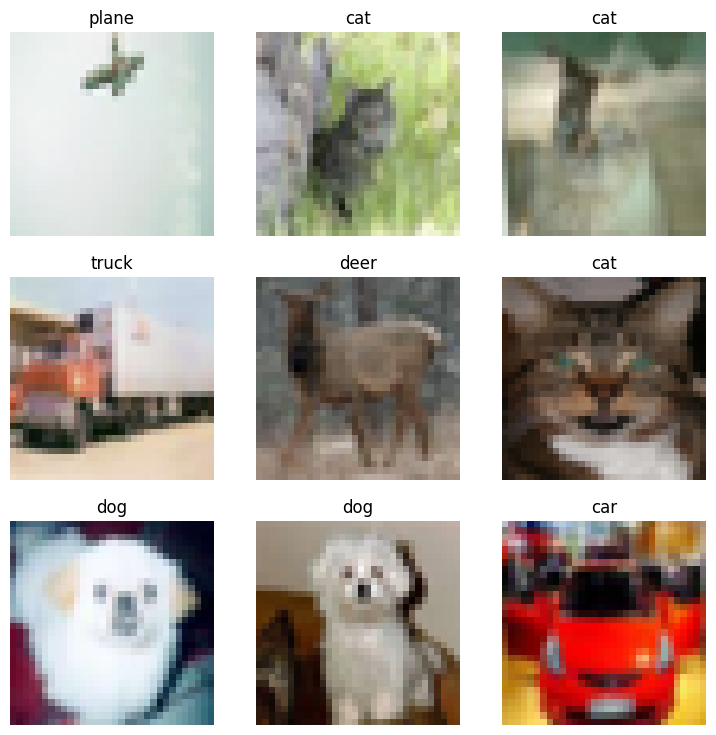

In [38]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create the appropriate transform, load/download CIFAR10 train and test datasets with transform
# ----------- <Your code> ---------------
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=transform)
# ----------- <End Your code> ---------------

# Define trainloader and testloader
# ----------- <Your code> ---------------
train_loader = torch.utils.data.DataLoader(trainset, batch_size=9, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=9, shuffle=False, num_workers=2)
# ----------- <End Your code> ---------------

# Code to display images
batch_idx, (images, targets) = next(enumerate(train_loader)) #fix!!!!!
fig, ax = plt.subplots(3,3,figsize = (9,9))
for i in range(3):
    for j in range(3):
        image = images[i*3+j].permute(1,2,0)
        image = image/2 + 0.5
        ax[i,j].imshow(image)
        ax[i,j].set_axis_off()
        ax[i,j].set_title(f'{classes[targets[i*3+j]]}')
fig.show()

### Task 2: Create CNN and train it
Set up a convolutional neural network and have your data trained on it. You have to decide all the details in your network, overall your neural network should meet the following standards to receive full credit:

*   You should not use more than three convolutional layers and three fully connected layers
*   Accuracy on the test dataset should be **above** 50%



In [39]:
# Create CNN network.
# ----------- <Your code> ---------------
class CfarCnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # input size = batchsize x 3 x 32 x 32
        x = self.pool(F.relu(self.conv1(x)))    # output size = batchsize x 6 x 14 x 14
        x = self.pool(F.relu(self.conv2(x)))    # output size = batchsize x 16 x 5 x 5
        x = torch.flatten(x, 1)                 # output size = batchsize x 400
        x = F.relu(self.fc1(x))                 # output size = batchsize x 120
        x = F.relu(self.fc2(x))                 # output size = batchsize x 84
        x = self.fc3(x)                         # output size = batchsize x 10
        return x
# ----------- <End Your code> ---------------

In [40]:
# Train your neural network here.
start = time.time()
max_epoch = 4
# ----------- <Your code> ---------------
# Define net
net = CfarCnn()
# Define loss function
criterion = nn.CrossEntropyLoss()
# Define optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# Move the model to the device
net.to(device)
# Training loop
for epoch in range(1, max_epoch+1):
  train(net, criterion, optimizer, train_loader, epoch)
# ----------- <End Your code> ---------------
output = test(net, criterion, test_loader, epoch)
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 1: [0/50000] Loss: 2.321708917617798
Epoch 1: [900/50000] Loss: 2.299635648727417
Epoch 1: [1800/50000] Loss: 2.2978734970092773
Epoch 1: [2700/50000] Loss: 2.290391683578491
Epoch 1: [3600/50000] Loss: 2.298146963119507
Epoch 1: [4500/50000] Loss: 2.295351982116699
Epoch 1: [5400/50000] Loss: 2.296144723892212
Epoch 1: [6300/50000] Loss: 2.28908634185791
Epoch 1: [7200/50000] Loss: 2.2900102138519287
Epoch 1: [8100/50000] Loss: 2.2798256874084473
Epoch 1: [9000/50000] Loss: 2.258164167404175
Epoch 1: [9900/50000] Loss: 2.1937971115112305
Epoch 1: [10800/50000] Loss: 2.2859363555908203
Epoch 1: [11700/50000] Loss: 2.2640109062194824
Epoch 1: [12600/50000] Loss: 2.221187114715576
Epoch 1: [13500/50000] Loss: 2.2097768783569336
Epoch 1: [14400/50000] Loss: 1.8516954183578491
Epoch 1: [15300/50000] Loss: 1.589654803276062
Epoch 1: [16200/50000] Loss: 2.2060043811798096
Epoch 1: [17100/50000] Loss: 1.932188630104065
Epoch 1: [18000/50000] Loss: 1.7408777475357056
Epoch 1: [18900/5000

### Task 3: Plot misclassified test images
Plot some misclassified images in your test dataset:

*   select three images that are **misclassified** by your neural network
*   label each images with true label and predicted label
*   use `detach().cpu()` when plotting images if the image is in gpu

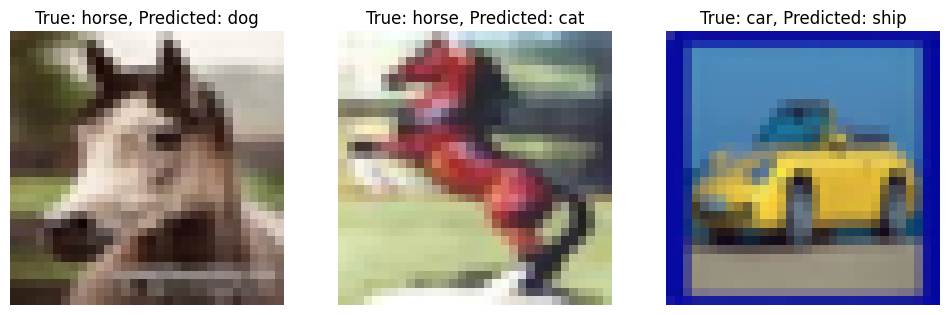

In [41]:
total_images = 3
predictions = output['prediction']
targets = torch.tensor(testset.targets)
# ----------- <Your code> ---------------
# Compare predictions with the ground truth labels to generate a binary mask
correct = predictions.detach().cpu().eq(targets.data.view_as(predictions))

# Find the indices of the misclassified images
misclassified_indices = torch.where(~correct)[0]

# Select N misclassified images randomly
torch.manual_seed(0)
num_misclassified = 3
misclassified_indices = misclassified_indices[torch.randperm(len(misclassified_indices))[:num_misclassified]]

# Load the first x misclassified images and their labels
misclassified_images = torch.stack([testset[i][0] for i in misclassified_indices])
misclassified_labels = torch.stack([targets[i] for i in misclassified_indices])

# Plot the images and display the true and predicted classes
fig, ax = plt.subplots(1, num_misclassified, figsize=(12, 6))
for i in range(num_misclassified):
    image = misclassified_images[i].permute(1,2,0)
    image = image/2 + 0.5
    ax[i].imshow(image)
    ax[i].set_title(f'True: {classes[misclassified_labels[i]]}, Predicted: {classes[predictions[misclassified_indices[i]]]}')
    ax[i].axis('off')
# ----------- <End Your code> ---------------    

Questions (0 points): Are the mis-classified images also misleading to human eyes?

Yes, although some of the correctly predicted ones are also misleading.

## Exercise 3: Transfer Learning (30 points)

In practice, people won't train an entire CNN from scratch, because it is relatively rare to have a dataset of sufficient size (or sufficient computational power). Instead, it is common to pretrain a CNN on a very large dataset and then use the CNN either as an initialization or a fixed feature extractor for the task of interest.

In this task, you will learn how to use a pretrained CNN for CIFAR-10 classification.

### Task1: Load pretrained model

`torchvision.models` (https://pytorch.org/vision/stable/models.html) contains definitions of models for addressing different tasks, including: image classification, pixelwise semantic segmentation, object detection, instance segmentation, person keypoint detection and video classification.

First, you should load the **pretrained** ResNet-18 that has already been trained on [ImageNet](https://www.image-net.org/) using `torchvision.models`. If you are interested in more details about Resnet-18, read this paper https://arxiv.org/pdf/1512.03385.pdf.

In [42]:
resnet18 = models.resnet18(pretrained=True)
resnet18 = resnet18.to(device)

/Users/crich/Development/School/ECE5700-AI/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/crich/Development/School/ECE5700-AI/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Task2: Create data loaders for CIFAR-10

Then you need to create a modified dataset and dataloader for CIFAR-10. Importantly, the model you load has been trained on **ImageNet** and it expects inputs as mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be **at least** 224. So you need to preprocess the CIFAR-10 data to make sure it has a height and width of 224. Thus, you should add a transform when loading the CIFAR10 dataset (see [`torchvision.transforms.Resize`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Resize)).
This should be added appropriately to the `transform` you created in a previous task.

In [43]:
# Create your dataloader here
# ----------- <Your code> ---------------
# Define the transform for cifar10 so that it is the correct size for resnet18
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
# ----------- <End Your code> ---------------

Files already downloaded and verified
Files already downloaded and verified


### Task3: Classify test data on pretrained model

Use the model you load to classify the **test** CIFAR-10 data and print out the test accuracy.

Don't be surprised if the accuracy is bad!

In [44]:
# ----------- <Your code> ---------------
criterion = nn.CrossEntropyLoss()
test(resnet18, criterion, test_loader);
# ----------- <End Your code> ---------------

Test result on epoch 0: total samples: 10000, Avg loss: 11.707, Acc: 0.030%


### Task 4: Fine-tune (i.e., update) the pretrained model for CIFAR-10

Now try to improve the test accuracy. We offer several possible solutions:

(1) You can try to directly continue to train the model you load with the CIFAR-10 training data. 

(2) For efficiency, you can try to freeze part of the parameters of the loaded models. For example, you can first freeze all parameters by

```
for param in model.parameters():
    param.requires_grad = False
```
and then unfreeze the last few layers by setting `somelayer.requires_grad=True`.

You are also welcome to try any other approach you can think of.


**Note:** You must print out the test accuracy and to get full credits, the test accuracy should be at least **80%**.

In [45]:
# Directly train the whole model.
start = time.time()
#----------- <Your code> ---------------
# Replace output layer to the resnet18 model for CIFAR10
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)
resnet18 = resnet18.to(device)
# Train
optimizer = optim.Adadelta(resnet18.parameters(), lr=2.0)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
max_epoch = 10
for epoch in range(1, max_epoch+1):
  train(resnet18, criterion, optimizer, train_loader, epoch)
  scheduler.step()

# ----------- <End Your code> ---------------
test(resnet18, criterion, test_loader, epoch)
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 1: [0/50000] Loss: 2.455737352371216
Epoch 1: [6400/50000] Loss: 1.8351480960845947
Epoch 1: [12800/50000] Loss: 1.4284050464630127
Epoch 1: [19200/50000] Loss: 1.1470718383789062
Epoch 1: [25600/50000] Loss: 1.1097432374954224
Epoch 1: [32000/50000] Loss: 0.8831242918968201
Epoch 1: [38400/50000] Loss: 0.7232311367988586
Epoch 1: [44800/50000] Loss: 0.806818962097168
Epoch 2: [0/50000] Loss: 1.260986566543579
Epoch 2: [6400/50000] Loss: 0.6820101737976074
Epoch 2: [12800/50000] Loss: 0.5606314539909363
Epoch 2: [19200/50000] Loss: 0.4148138761520386
Epoch 2: [25600/50000] Loss: 0.7936642169952393
Epoch 2: [32000/50000] Loss: 0.8733022212982178
Epoch 2: [38400/50000] Loss: 0.7558035850524902
Epoch 2: [44800/50000] Loss: 0.3233976364135742
Epoch 3: [0/50000] Loss: 0.3677864670753479
Epoch 3: [6400/50000] Loss: 0.6645601987838745
Epoch 3: [12800/50000] Loss: 0.3766672611236572
Epoch 3: [19200/50000] Loss: 0.4428384304046631
Epoch 3: [25600/50000] Loss: 0.4343269467353821
Epoch 3: [

In [46]:
# Load another resnet18 instance, only unfreeze the outer layers. 
# ----------- <Your code> ---------------
# Helper function to print model layers
def print_model_layers(model: nn.Module):
    for name, layer in model.named_modules():
        print(name, layer)

# Define model with output layer replaced for CIFAR10
resnet18 = models.resnet18(pretrained=True)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)
resnet18 = resnet18.to(device)
# print_model_layers(resnet18)

# Freeze all the layers in the model
for param in resnet18.parameters():
    param.requires_grad = False

# Unfreeze the last layer
for param in resnet18.fc.parameters():
    param.requires_grad = True
# ----------- <End Your code> ---------------

In [47]:
# Train the model!!
start = time.time()
# ----------- <Your code> ---------------
optimizer = optim.Adadelta(resnet18.parameters(), lr=2.0)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
max_epoch = 10
for epoch in range(1, max_epoch+1):
  train(resnet18, criterion, optimizer, train_loader, epoch)
  scheduler.step()
# ----------- <End Your code> ---------------
test(resnet18, criterion, test_loader)
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 1: [0/50000] Loss: 2.4513375759124756
Epoch 1: [6400/50000] Loss: 0.8223788738250732
Epoch 1: [12800/50000] Loss: 1.011115550994873
Epoch 1: [19200/50000] Loss: 1.0958218574523926
Epoch 1: [25600/50000] Loss: 0.530171811580658
Epoch 1: [32000/50000] Loss: 0.9504736065864563
Epoch 1: [38400/50000] Loss: 0.6550635695457458
Epoch 1: [44800/50000] Loss: 0.865522027015686
Epoch 2: [0/50000] Loss: 1.84061598777771
Epoch 2: [6400/50000] Loss: 0.3884732127189636
Epoch 2: [12800/50000] Loss: 0.7712877988815308
Epoch 2: [19200/50000] Loss: 1.094550609588623
Epoch 2: [25600/50000] Loss: 0.9703587293624878
Epoch 2: [32000/50000] Loss: 0.5292966365814209
Epoch 2: [38400/50000] Loss: 0.5936389565467834
Epoch 2: [44800/50000] Loss: 0.43292999267578125
Epoch 3: [0/50000] Loss: 0.767737627029419
Epoch 3: [6400/50000] Loss: 0.690311074256897
Epoch 3: [12800/50000] Loss: 0.5836412906646729
Epoch 3: [19200/50000] Loss: 0.7930392026901245
Epoch 3: [25600/50000] Loss: 0.9157977104187012
Epoch 3: [3200